In [4]:
import numpy as np
import pandas as pd
from log_analysis import (get_unique_tcp_stream_ids, load_timestamps_from_crawl_data,
                          get_distinct_tcp_conns, get_crawl_data_path,
                          get_crawl_status, get_epoch)

from os.path import isdir, join
from datetime import datetime
from glob import glob

ROKU_WARMUP_CRAWL = 'roku-data-20190427-014017'
crawl_data_dir_roku = get_crawl_data_path(ROKU_WARMUP_CRAWL)

In [5]:
assert isdir(crawl_data_dir_roku)

In [6]:
crawl_results = get_crawl_status(crawl_data_dir_roku)

## Load timestamps

In [7]:
channel_timestamps = load_timestamps_from_crawl_data(crawl_data_dir_roku)

longest_label_set = max(list(channel_timestamps.values()), key=len)
label_set = [i[0] for i in longest_label_set]
smart_crawl_labels = list(filter(lambda x: 'key-seq' in x, label_set))


Loading timestamp data from /home/gacar/dev/smart-tv/data/roku-data-20190427-014017


In [37]:
def get_launch_no(epoch):
    launch_idx = int(epoch.split("-", 2)[1])
    if "smartlaunch" in epoch:
        return 10 + launch_idx
    elif "launch" in epoch:
        return launch_idx

/home/gacar/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [10]:
# Load all (All SSL/TCP Streams)
def get_stream_df(crawl_name, channel_timestamps):
    crawl_data_dir = get_crawl_data_path(crawl_name)
    print (crawl_data_dir)
    post_process_dir = join(crawl_data_dir, 'post-process')
    ssl_df = get_distinct_tcp_conns(crawl_data_dir)
    ssl_df = ssl_df[ssl_df.tcp_dstport == 443]
    #Add SSL artifacts 
    # ssl_fails = get_tcp_conns(post_process_dir, "*.pcap.ssl_fail")
    ssl_attempts = get_unique_tcp_stream_ids(post_process_dir, "*.pcap.mitmproxy-attempt")
    ssl_success = get_unique_tcp_stream_ids(post_process_dir, "*.pcap.ssl_connections")
    # print(ssl_success)
    ssl_df['mitm_attempt'] = ssl_df.apply(lambda x: x['tcp_stream'] in ssl_attempts[x['channel_id']], axis=1)
    # ssl_df['mitm_fail'] = ssl_df.apply(lambda x: x['tcp.stream'] in ssl_fails[x['channel_id']], axis=1)
    # mitm_fail doesn't capture some corner cases, we should test and use mitm success
    ssl_df['ssl_success'] = ssl_df.apply(lambda x: x['tcp_stream'] in ssl_success[x['channel_id']], axis=1)
    ssl_df["crawl_status"] = ssl_df["channel_id"].map(lambda x: crawl_results[x])
    ssl_df['epoch'] = ssl_df.apply(lambda x: get_epoch(x, channel_timestamps), axis=1)
    ssl_df['n_smart_crawl_launch'] = ssl_df['epoch'].map(lambda x: int(x.split('-')[1]) if 'key-seq' in x else -1)
    ssl_df['launch_no'] = ssl_df.epoch.map(lambda x: "-".join(x.split("-", 2)[:2]))
    ssl_df['launch_no_int'] = ssl_df.epoch.map(get_launch_no)
    return ssl_df

In [12]:
roku_df = get_stream_df(ROKU_WARMUP_CRAWL, channel_timestamps)

/home/gacar/dev/smart-tv/data/roku-data-20190427-014017
Loading distinct TCP connections from /home/gacar/dev/smart-tv/data/roku-data-20190427-014017/post-process 


### Crawl outcome
- `TERMINATED` means success

In [13]:
roku_df.drop_duplicates("channel_id").crawl_status.value_counts()

TERMINATED    141
INSTALLING      9
Name: crawl_status, dtype: int64

## Make sure all missing epoch are due to unfinished crawls

In [14]:
assert len(roku_df[(roku_df.epoch == "unknown") & (roku_df.crawl_status == "TERMINATED")]) == 0

In [15]:
print ("Roku", len(roku_df[(roku_df.epoch == "unknown")]))

Roku 164


## Filter out connections from channels that could not be scraped

In [16]:
roku_df = roku_df[(roku_df.epoch != "unknown") & (roku_df.crawl_status == "TERMINATED")]

## MITM Succes rate

In [17]:
roku_attempts = roku_df[roku_df.mitm_attempt]
roku_fails  = roku_attempts[~roku_attempts.ssl_success]
roku_successes  = roku_attempts[roku_attempts.ssl_success]
n_roku_attempts = len(roku_attempts)

In [18]:
print (len(roku_df), "total SSL connections to", roku_df.host_by_dns.nunique(), "distinct hosts\n",
            n_roku_attempts, "SSL MITM attempts to", roku_attempts.host_by_dns.nunique(), "distinct hosts\n",
              len(roku_successes), "successfully MITMed SSL connections to",
       roku_successes.host_by_dns.nunique(), "distinct hosts in",
       roku_successes.channel_id.nunique(), "distinct channels\n",
      "Success rate (n_successes/n_attempts): %0.1f%%" % (100*len(roku_successes)/n_roku_attempts))

41301 total SSL connections to 473 distinct hosts
 1298 SSL MITM attempts to 313 distinct hosts
 267 successfully MITMed SSL connections to 4 distinct hosts in 3 distinct channels
 Success rate (n_successes/n_attempts): 20.6%


In [19]:
roku_successes.drop_duplicates(['host_by_dns', 'channel_id'])[['channel_id', 'host_by_dns']]

,channel_id,host_by_dns
5,90131,api.yuyutv.com
19,68669,ws-cloudpath.media.nbcuni.com
20,13842,vudu.d1.sc.omtrdc.net
22,13842,images2.vudu.com


### Make sure we don't have missing DNS data
- TODO: we don't isolate IP-domain mappings by channel. Should we parse pcaps instead of using Redis dumps?

In [20]:
print(len(roku_df[(roku_df.host_by_dns =="unknown") | (roku_df.host_by_dns =="")]))

39


### SSL fails without MITM attempt
- Using the pcaps we verified that these SSL failures are due to issues such as Unknown CA (not caused by mitmproxy).

### MITM fails breakdown by stage - relaunches and smart crawls

In [21]:
roku_relaunch_fails = roku_fails[roku_fails.epoch.str.contains('launch-') &
                                     ~roku_fails.epoch.str.contains('key-seq')]

roku_smartcrawl_fails = roku_fails[roku_fails.epoch.str.contains('key-seq')]


print ("Roku Relaunch", len(roku_relaunch_fails), roku_relaunch_fails.host_by_dns.nunique())
print ("Roku Smart crawl", len(roku_smartcrawl_fails), roku_smartcrawl_fails.host_by_dns.nunique())

Roku Relaunch 494 154
Roku Smart crawl 537 181


In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(6,3)}, style="darkgrid")
sns.set(font_scale = 0.8)

In [23]:
def plot_ssl_by(df, filename=None, group_by="epoch",rotation=45,
                xlabel='Launch number', ylabel='Number of SSL errors'):
    g = sns.countplot(data=df.sort_values(group_by), x=group_by)
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    g.set(xlabel=xlabel, ylabel=ylabel)
    if filename is not None:
        g.get_figure().savefig(filename, bbox_inches='tight')
    g

## SSL connections by epoch

In [83]:
# plot_ssl_by(roku_df)

## MITM fails by launch number

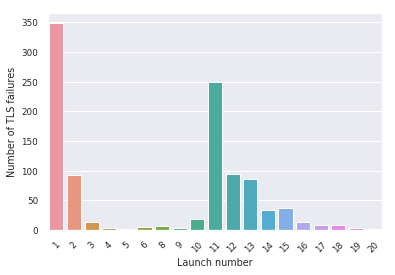

In [80]:
plot_ssl_by(roku_fails, group_by="launch_no_int",
            filename="roku_ssl_fails_launch_no_combined.pdf",
           xlabel='Launch number', ylabel='Number of TLS failures')

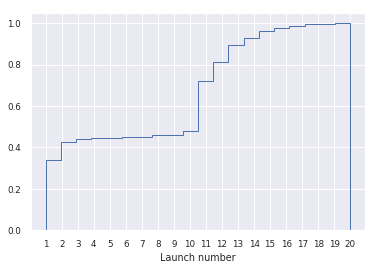

In [77]:
ax = roku_fails['launch_no_int'].hist(cumulative=True, bins=20, density=True, histtype="step")
ax.set(xlabel="Launch number")
plt.xticks(np.arange(min(roku_fails['launch_no_int']), max(roku_fails['launch_no_int'])+1, 1.0))
fig = ax.get_figure()
fig.savefig('cdf_warmup_param_selection_step.pdf', bbox_inches='tight')

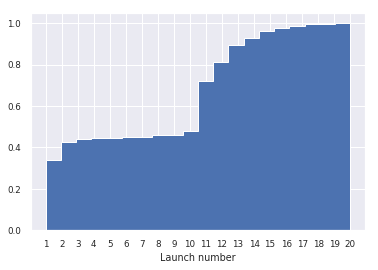

In [78]:
ax = roku_fails['launch_no_int'].hist(cumulative=True, bins=20, density=True, histtype="stepfilled")
ax.set(xlabel="Launch number")
plt.xticks(np.arange(min(roku_fails['launch_no_int']), max(roku_fails['launch_no_int'])+1, 1.0))
fig = ax.get_figure()
fig.savefig('cdf_warmup_param_selection_stepfilled.pdf', bbox_inches='tight')

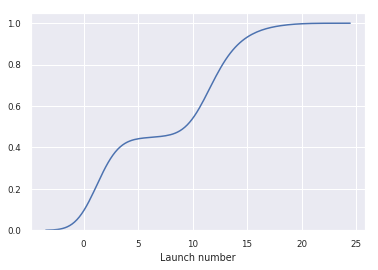

In [79]:
ax = sns.kdeplot(roku_fails['launch_no_int'], cumulative=True, legend=False)
ax.set(xlabel="Launch number")
#plt.xticks(np.arange(min(roku_fails['launch_no_int']), max(roku_fails['launch_no_int'])+1, 1.0))
fig = ax.get_figure()
fig.savefig('kde_warmup_param_selection.pdf', bbox_inches='tight')

## Parameter selection

In [56]:
n_ssl_errs_after_5th_smart_crawl = len(roku_fails[roku_fails.n_smart_crawl_launch > 5])

In [57]:
n_ssl_errs_before_5th_smart_crawl = len(roku_fails[roku_fails.n_smart_crawl_launch <= 5])

In [58]:
cdf_at_5th_smart = 100*n_ssl_errs_before_5th_smart_crawl / (n_ssl_errs_after_5th_smart_crawl + n_ssl_errs_before_5th_smart_crawl)
print("%0.1f%% of the errors are encountered on or before 5th smart crawl" % cdf_at_5th_smart)

96.4% of the errors are encountered on or before 5th smart crawl


### MITM Fails during smart crawl

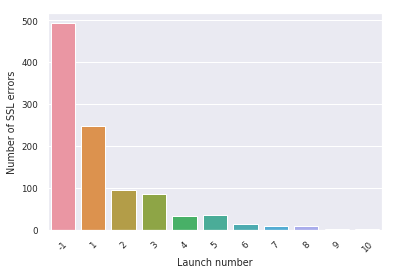

In [48]:
plot_ssl_by(roku_fails, group_by='n_smart_crawl_launch')

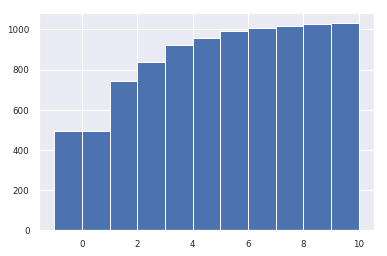

In [49]:
roku_fails['n_smart_crawl_launch'].hist(cumulative=True, bins=11)

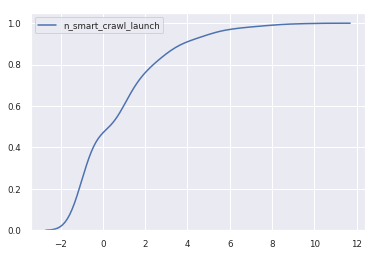

In [50]:
group_by = "n_smart_crawl_launch"
sns.kdeplot(roku_fails['n_smart_crawl_launch']
            , cumulative=True
           )


### MITM Fails during channel relaunch

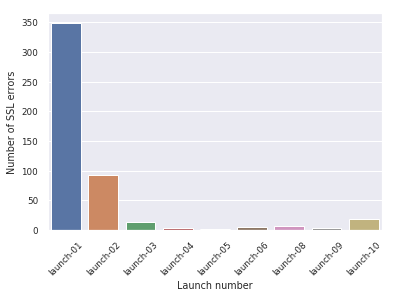

In [81]:
plot_ssl_by(roku_relaunch_fails, filename="images/roku_relaunch_fails.pdf")

## Late stage MITM fails
- why do we still have mitm fails in later stages
- it looks like, these are indeer hosts we have not seen before

In [42]:
roku_fails[roku_fails.n_smart_crawl_launch > 5].host_by_dns.value_counts().head(10)

www.google-analytics.com        4
secure-gl.imrworldwide.com      2
d.agkn.com                      2
ade.googlesyndication.com       2
secure-gg.imrworldwide.com      2
us-west-2.event.prod.bidr.io    2
pixel.mtrcs.samba.tv            1
redirector.gvt1.com             1
imtwjwoasak.com                 1
secure.insightexpressai.com     1
Name: host_by_dns, dtype: int64

In [43]:
# No of channels failing on last smart crawl attempt
print(roku_smartcrawl_fails[roku_smartcrawl_fails.n_smart_crawl_launch==4].channel_id.nunique(),  roku_df.channel_id.nunique())

13 141


In [44]:
print(roku_smartcrawl_fails[roku_smartcrawl_fails.n_smart_crawl_launch==3].channel_id.nunique(),  roku_df.channel_id.nunique())

25 141
